In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import ElasticNet
import logging
import sys
import json
import os
from datetime import datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sns.set_palette("Dark2")

In [3]:
config_file = '../../configs/cancer_type/lgbm_grid_search_tissuetype.json'
configs = json.load(open(config_file, 'r'))

In [4]:
seed = configs['seed']
cv = StratifiedKFold(n_splits=configs['cv'], shuffle=True, random_state=seed)

data_sample = pd.read_csv('../../data/cancer_type/cancer_tissue_type_protein.tsv', sep='\t')

data_sample = data_sample.drop(['Cell_line'], axis=1)

type_count = data_sample.groupby([configs['target']]).size()
selected_types = type_count[type_count > configs['cut_off']].index.values
data_sample = data_sample[data_sample[configs['target']].isin(selected_types)].reset_index(drop=True)
proteins = np.array([x for x in data_sample.columns if '_HUMAN' in x])
X = data_sample[proteins]
y = data_sample[configs['target']]
imputer = None
if configs['imputer'] == 'mean':
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
elif configs['imputer'] == 'KNN':
    imputer = KNNImputer(missing_values=np.nan)
elif configs['imputer'] == 'zero':
    imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
elif configs['imputer'] == 'min':
    imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=configs['min_val'])

if imputer:
    X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, shuffle=True,
                                                    test_size=0.2)

In [5]:
meta = pd.read_csv('../../data/E0022_P06_final_sample_map_no_control.txt',
                   sep='\t').set_index('Cell_line')

In [6]:
colour_list = pd.read_csv('../../data/colour_list.txt',header=None)[0].tolist()
cancer_colours = dict(
    zip(meta['Cancer_type'].unique(),
        colour_list[:meta['Cancer_type'].unique().size]))

tissue_colours = dict(
    zip(meta['Tissue_type'].unique(),
        colour_list[:meta['Tissue_type'].unique().size]))

# LGBM

In [31]:
params = {
    'max_bin': 500,
    'n_estimators': 700,
    'num_leaves': 21,
    'n_jobs': -1,
    'random_state': 42
}
clf = LGBMClassifier(**params)

In [8]:
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_bin=500,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=700, n_jobs=-1, num_leaves=21,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [9]:
y_pred = clf.predict(X_test)

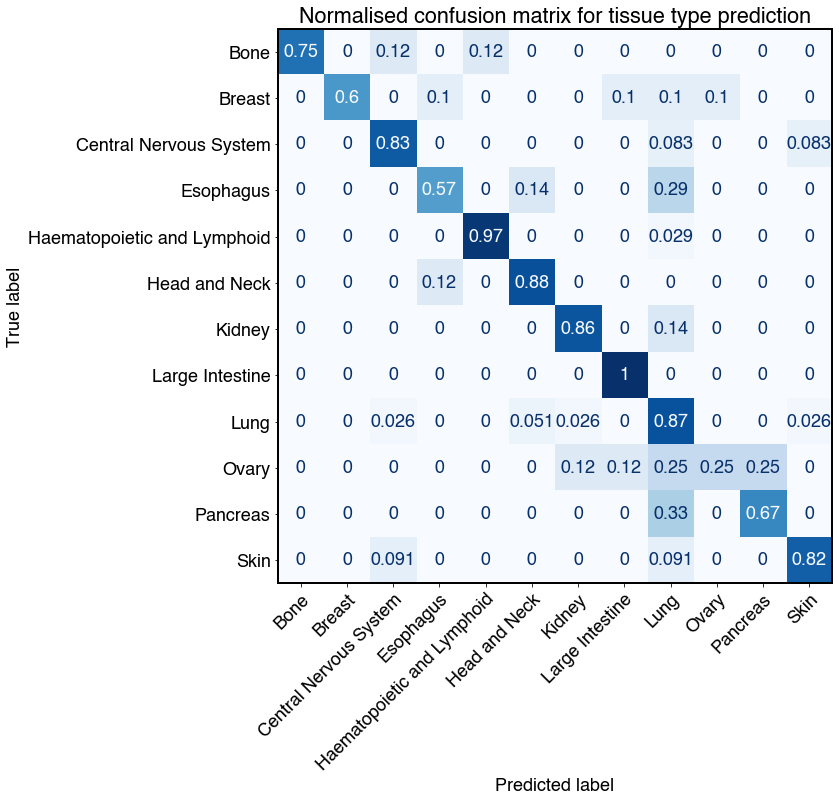

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 12))
plot_confusion_matrix(clf,
                      X_test,
                      y_test,
                      cmap=plt.cm.Blues,
                      ax=ax,
                      normalize='true')
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.title("Normalised confusion matrix for tissue type prediction")
ax.images[-1].colorbar.remove()
plt.tight_layout()
# plt.savefig("../../plots/landscape/tissue_type_confusion.pdf", dpi=500)

In [11]:
print(classification_report(y_test, y_pred))

                             precision    recall  f1-score   support

                       Bone       1.00      0.75      0.86         8
                     Breast       1.00      0.60      0.75        10
     Central Nervous System       0.77      0.83      0.80        12
                  Esophagus       0.67      0.57      0.62         7
Haematopoietic and Lymphoid       0.97      0.97      0.97        34
              Head and Neck       0.70      0.88      0.78         8
                     Kidney       0.75      0.86      0.80         7
            Large Intestine       0.83      1.00      0.91        10
                       Lung       0.76      0.87      0.81        39
                      Ovary       0.67      0.25      0.36         8
                   Pancreas       0.67      0.67      0.67         6
                       Skin       0.82      0.82      0.82        11

                   accuracy                           0.82       160
                  macro avg     

In [12]:
explainer = shap.TreeExplainer(clf)
lgbm_shap_values = explainer.shap_values(X)

In [29]:
colors = [tissue_colours[x] for x in sorted(set(y))]
def c(i):
    return colors[i]

In [42]:
name_map = pd.read_csv("../../data/misc/HUMAN_9606_idmapping.gene_prot.dat",
                       sep='\t',
                       names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()

name_map_dict = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))
for x in set(data_sample.iloc[:, :-2].columns):
    if x not in name_map_dict:
        name_map_dict[x] = 'NA'

In [43]:
feature_names = [name_map_dict[x] for x in data_sample.iloc[:, :-2].columns]

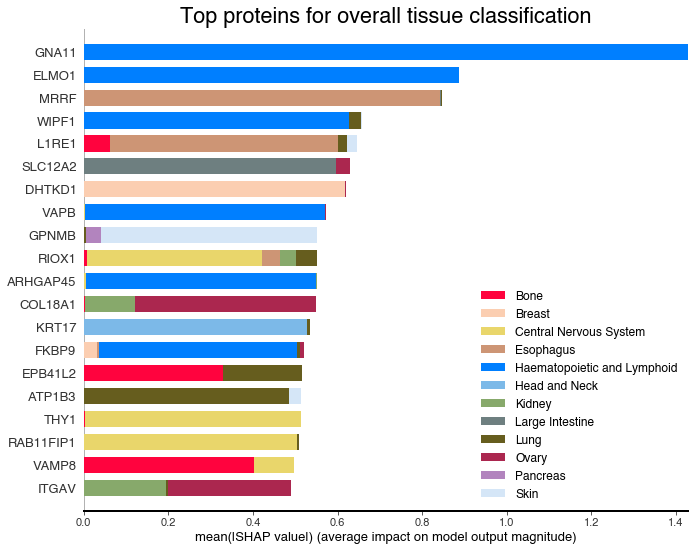

In [44]:
plt.figure(figsize=(10, 8))

plt.title("Top proteins for overall tissue classification")
shap.summary_plot(lgbm_shap_values,
                  feature_names,
                  class_inds='original',
                  class_names=sorted(set(y)),
                  show=False,
                  plot_size=None,
                  color=c)
plt.tight_layout()
# plt.savefig("../../plots/landscape/tissue_type_overall_shap.pdf", dpi=500)

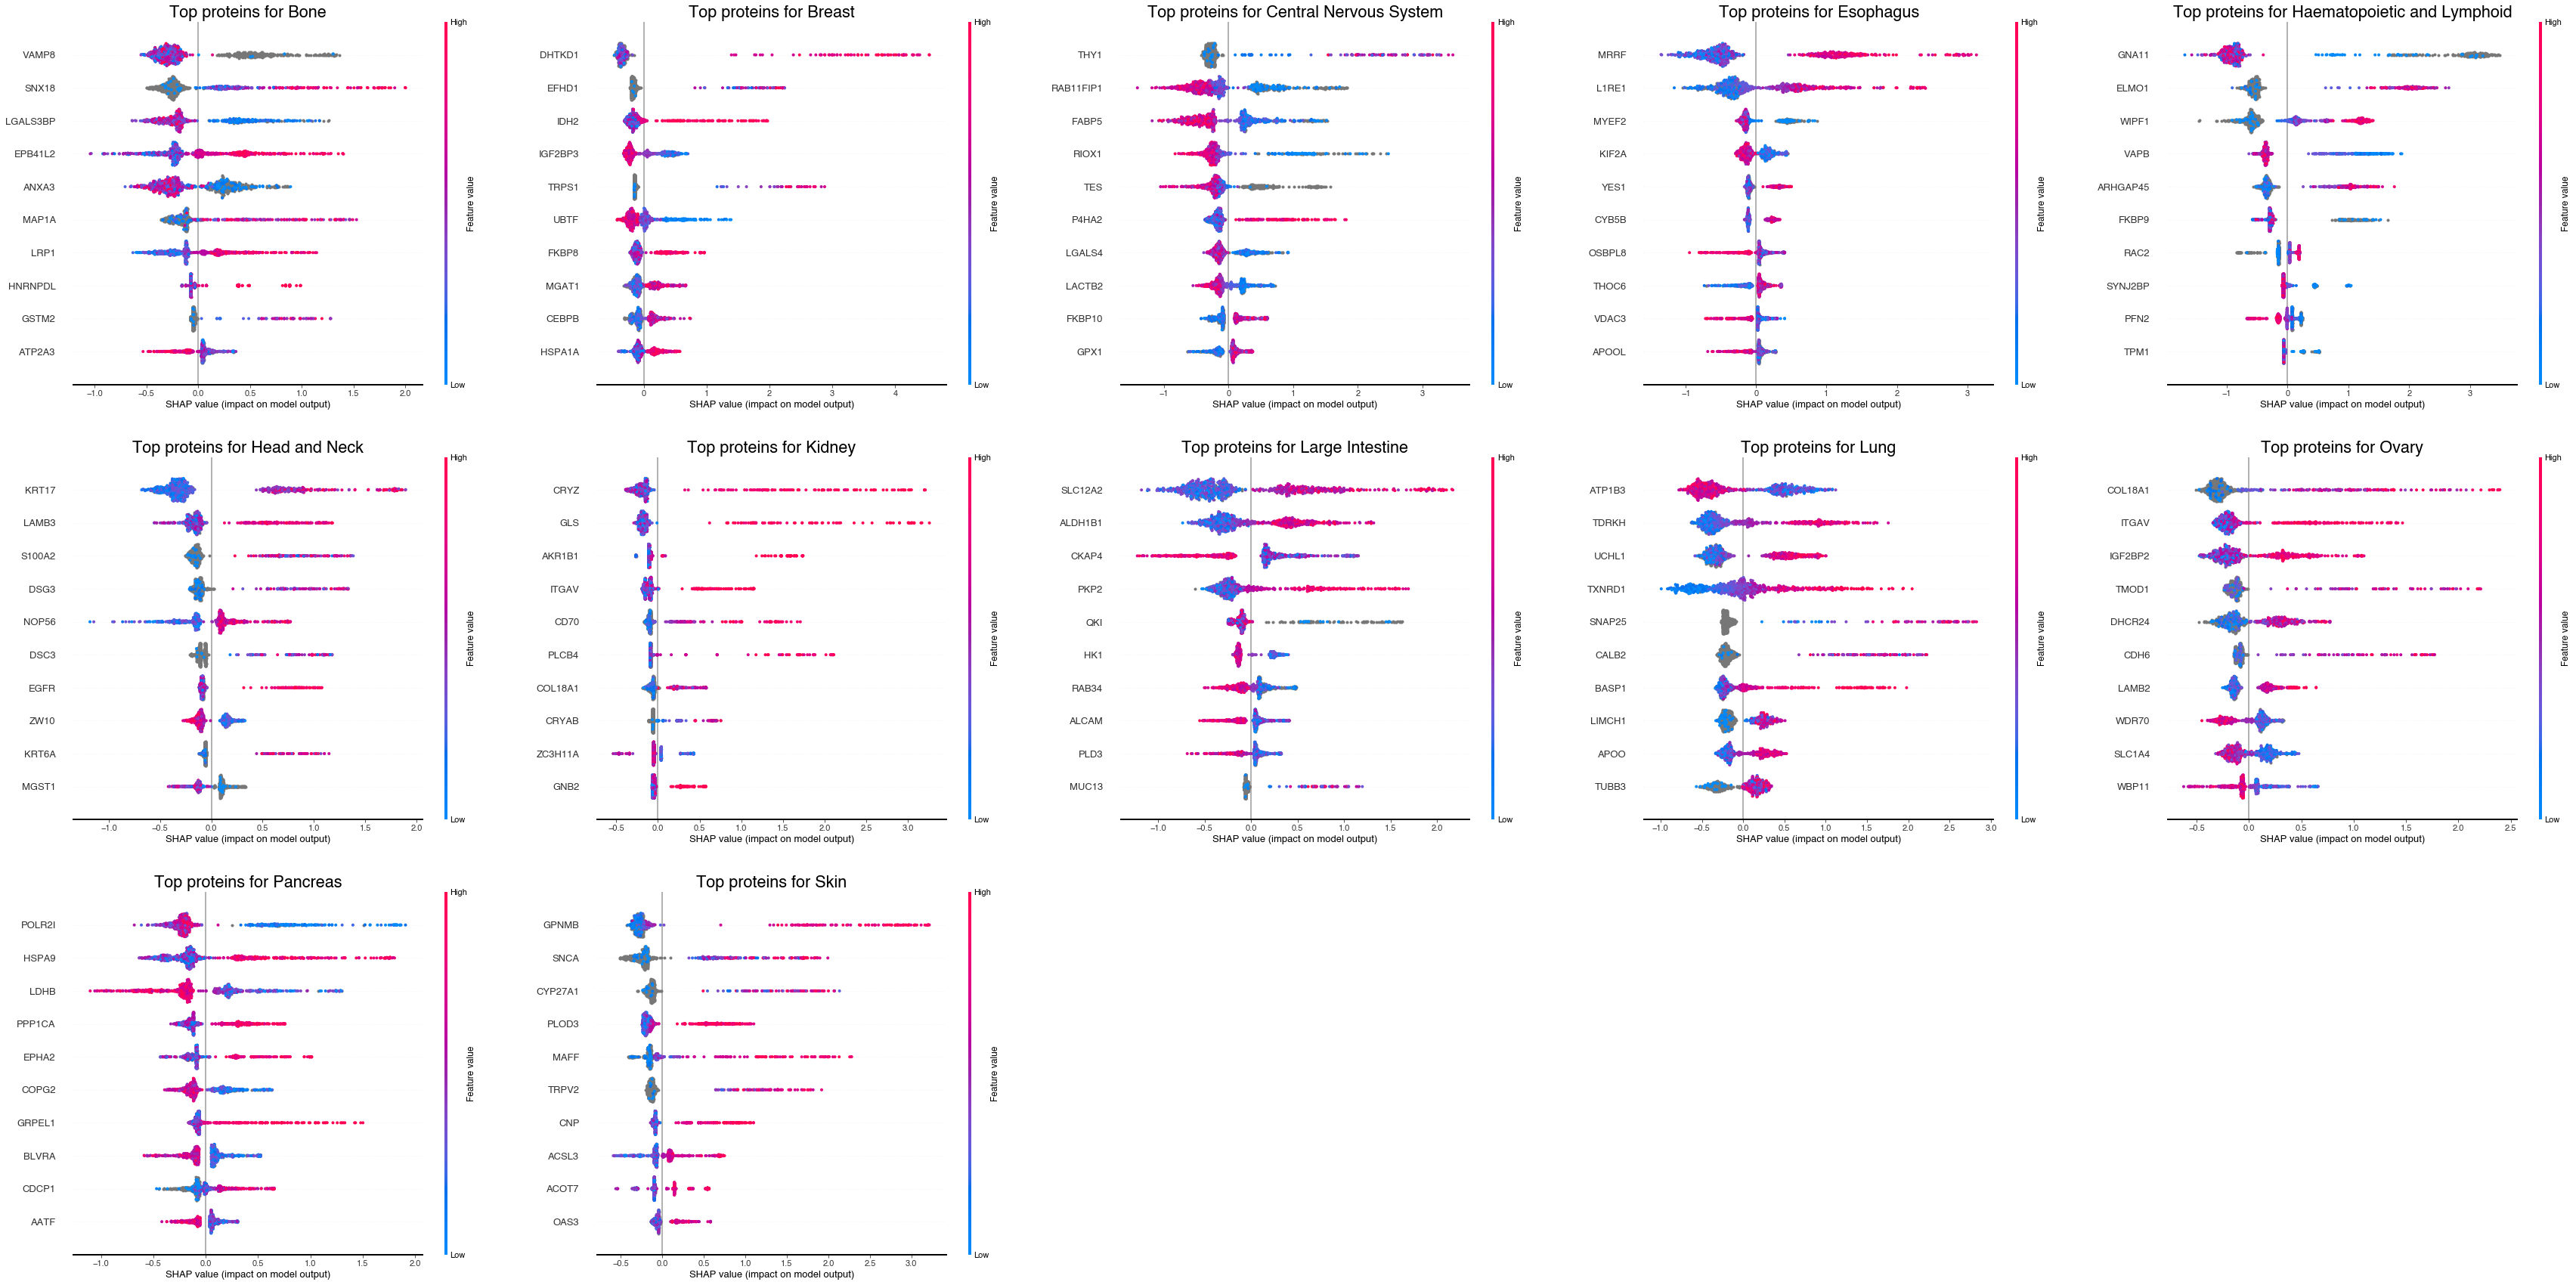

In [46]:
plt.figure(figsize=(60, 30))
for i in range(len(sorted(set(y)))):
    tissue_type = sorted(set(y))[i]
    plt.subplot(3, 5, i + 1)
    plt.title(f'Top proteins for {tissue_type}')
    shap.summary_plot(lgbm_shap_values[i],
                      data_sample.iloc[:, :-2],
                      feature_names=feature_names,
                      max_display=10,
                      show=False,
                      plot_size=None)
#     ax[i // 5, i % 5].figure = fig

# Random Forest

In [65]:
params = {'n_estimators': 25000, 'n_jobs': -1}
clf = RandomForestClassifier()

In [66]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [67]:
y_pred = clf.predict(X_test)

Text(0.5, 1.0, 'Normalised confusion matrix for tissue type prediction')

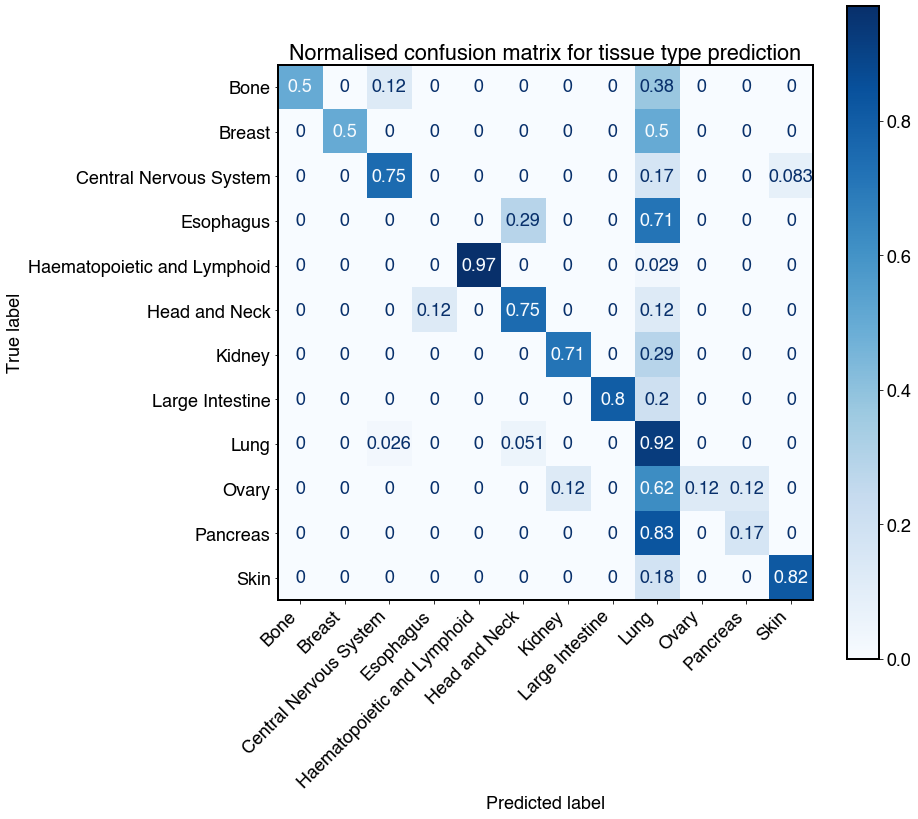

In [68]:
fig, ax = plt.subplots(1, figsize=(12, 12))
plot_confusion_matrix(clf,
                      X_test,
                      y_test,
                      cmap=plt.cm.Blues,
                      ax=ax,
                      normalize='true')
plt.xticks(rotation=45, ha='right')
plt.title("Normalised confusion matrix for tissue type prediction")

In [69]:
print(classification_report(y_test, y_pred))

                             precision    recall  f1-score   support

                       Bone       1.00      0.50      0.67         8
                     Breast       1.00      0.50      0.67        10
     Central Nervous System       0.82      0.75      0.78        12
                  Esophagus       0.00      0.00      0.00         7
Haematopoietic and Lymphoid       1.00      0.97      0.99        34
              Head and Neck       0.60      0.75      0.67         8
                     Kidney       0.83      0.71      0.77         7
            Large Intestine       1.00      0.80      0.89        10
                       Lung       0.52      0.92      0.67        39
                      Ovary       1.00      0.12      0.22         8
                   Pancreas       0.50      0.17      0.25         6
                       Skin       0.90      0.82      0.86        11

                   accuracy                           0.73       160
                  macro avg     

In [ ]:
explainer = shap.TreeExplainer(clf, feature_perturbation='interventional')
rf_shap_values = explainer.shap_values(X)

In [ ]:
plt.title("Top proteins for overall tissue classification")
shap.summary_plot(rf_shap_values,
                  data_sample.iloc[:, :-2],
                  class_inds='original',
                  class_names=sorted(set(y)))


In [ ]:
plt.figure(figsize=(60, 30))
for i in range(len(sorted(set(y)))):
    tissue_type = sorted(set(y))[i]
    plt.subplot(3, 5, i + 1)
    plt.title(f'Top proteins for {tissue_type}')
    shap.summary_plot(rf_shap_values[i],
                      data_sample.iloc[:, :-2],
                      max_display=10,
                      show=False,
                      plot_size=None)
#     ax[i // 5, i % 5].figure = fig

# XGBoost

In [156]:
params = {'n_estimators': 300, 'n_jobs': -1}
clf = XGBClassifier()

In [157]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [150]:
y_pred = clf.predict(X_test)

Text(0.5, 1.0, 'Normalised confusion matrix for tissue type prediction')

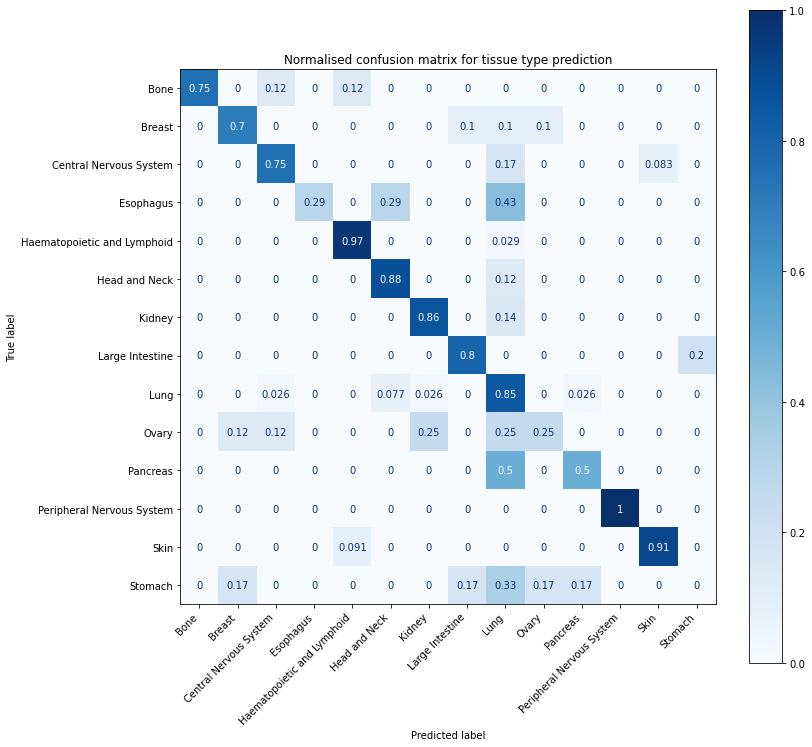

In [158]:
fig, ax = plt.subplots(1, figsize=(12, 12))
plot_confusion_matrix(clf,
                      X_test,
                      y_test,
                      cmap=plt.cm.Blues,
                      ax=ax,
                      normalize='true')
plt.xticks(rotation=45, ha='right')
plt.title("Normalised confusion matrix for tissue type prediction")

In [159]:
print(classification_report(y_test, y_pred))

                             precision    recall  f1-score   support

                       Bone       1.00      0.62      0.77         8
                     Breast       1.00      0.40      0.57        10
     Central Nervous System       0.82      0.75      0.78        12
                  Esophagus       0.00      0.00      0.00         7
Haematopoietic and Lymphoid       1.00      0.97      0.99        34
              Head and Neck       0.58      0.88      0.70         8
                     Kidney       0.71      0.71      0.71         7
            Large Intestine       0.88      0.70      0.78        10
                       Lung       0.46      0.90      0.61        39
                      Ovary       1.00      0.12      0.22         8
                   Pancreas       0.00      0.00      0.00         6
  Peripheral Nervous System       1.00      0.67      0.80         6
                       Skin       0.91      0.91      0.91        11
                    Stomach      

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [160]:
explainer = shap.TreeExplainer(clf)
xgb_shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


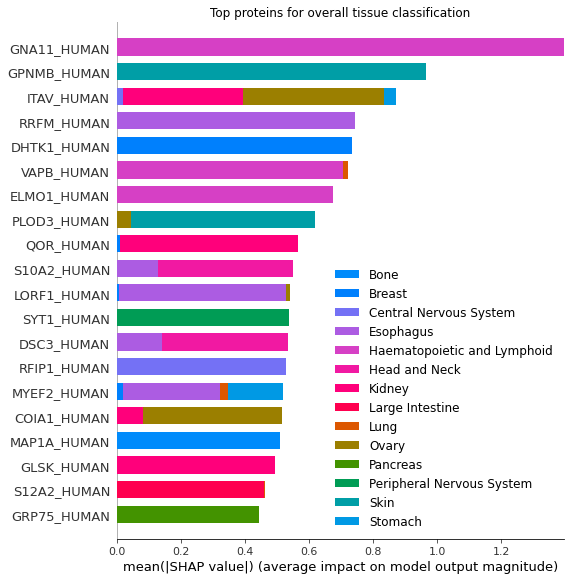

In [161]:
plt.title("Top proteins for overall tissue classification")
shap.summary_plot(xgb_shap_values,
                  data_sample.iloc[:, :-2],
                  class_inds='original',
                  class_names=sorted(set(y)))


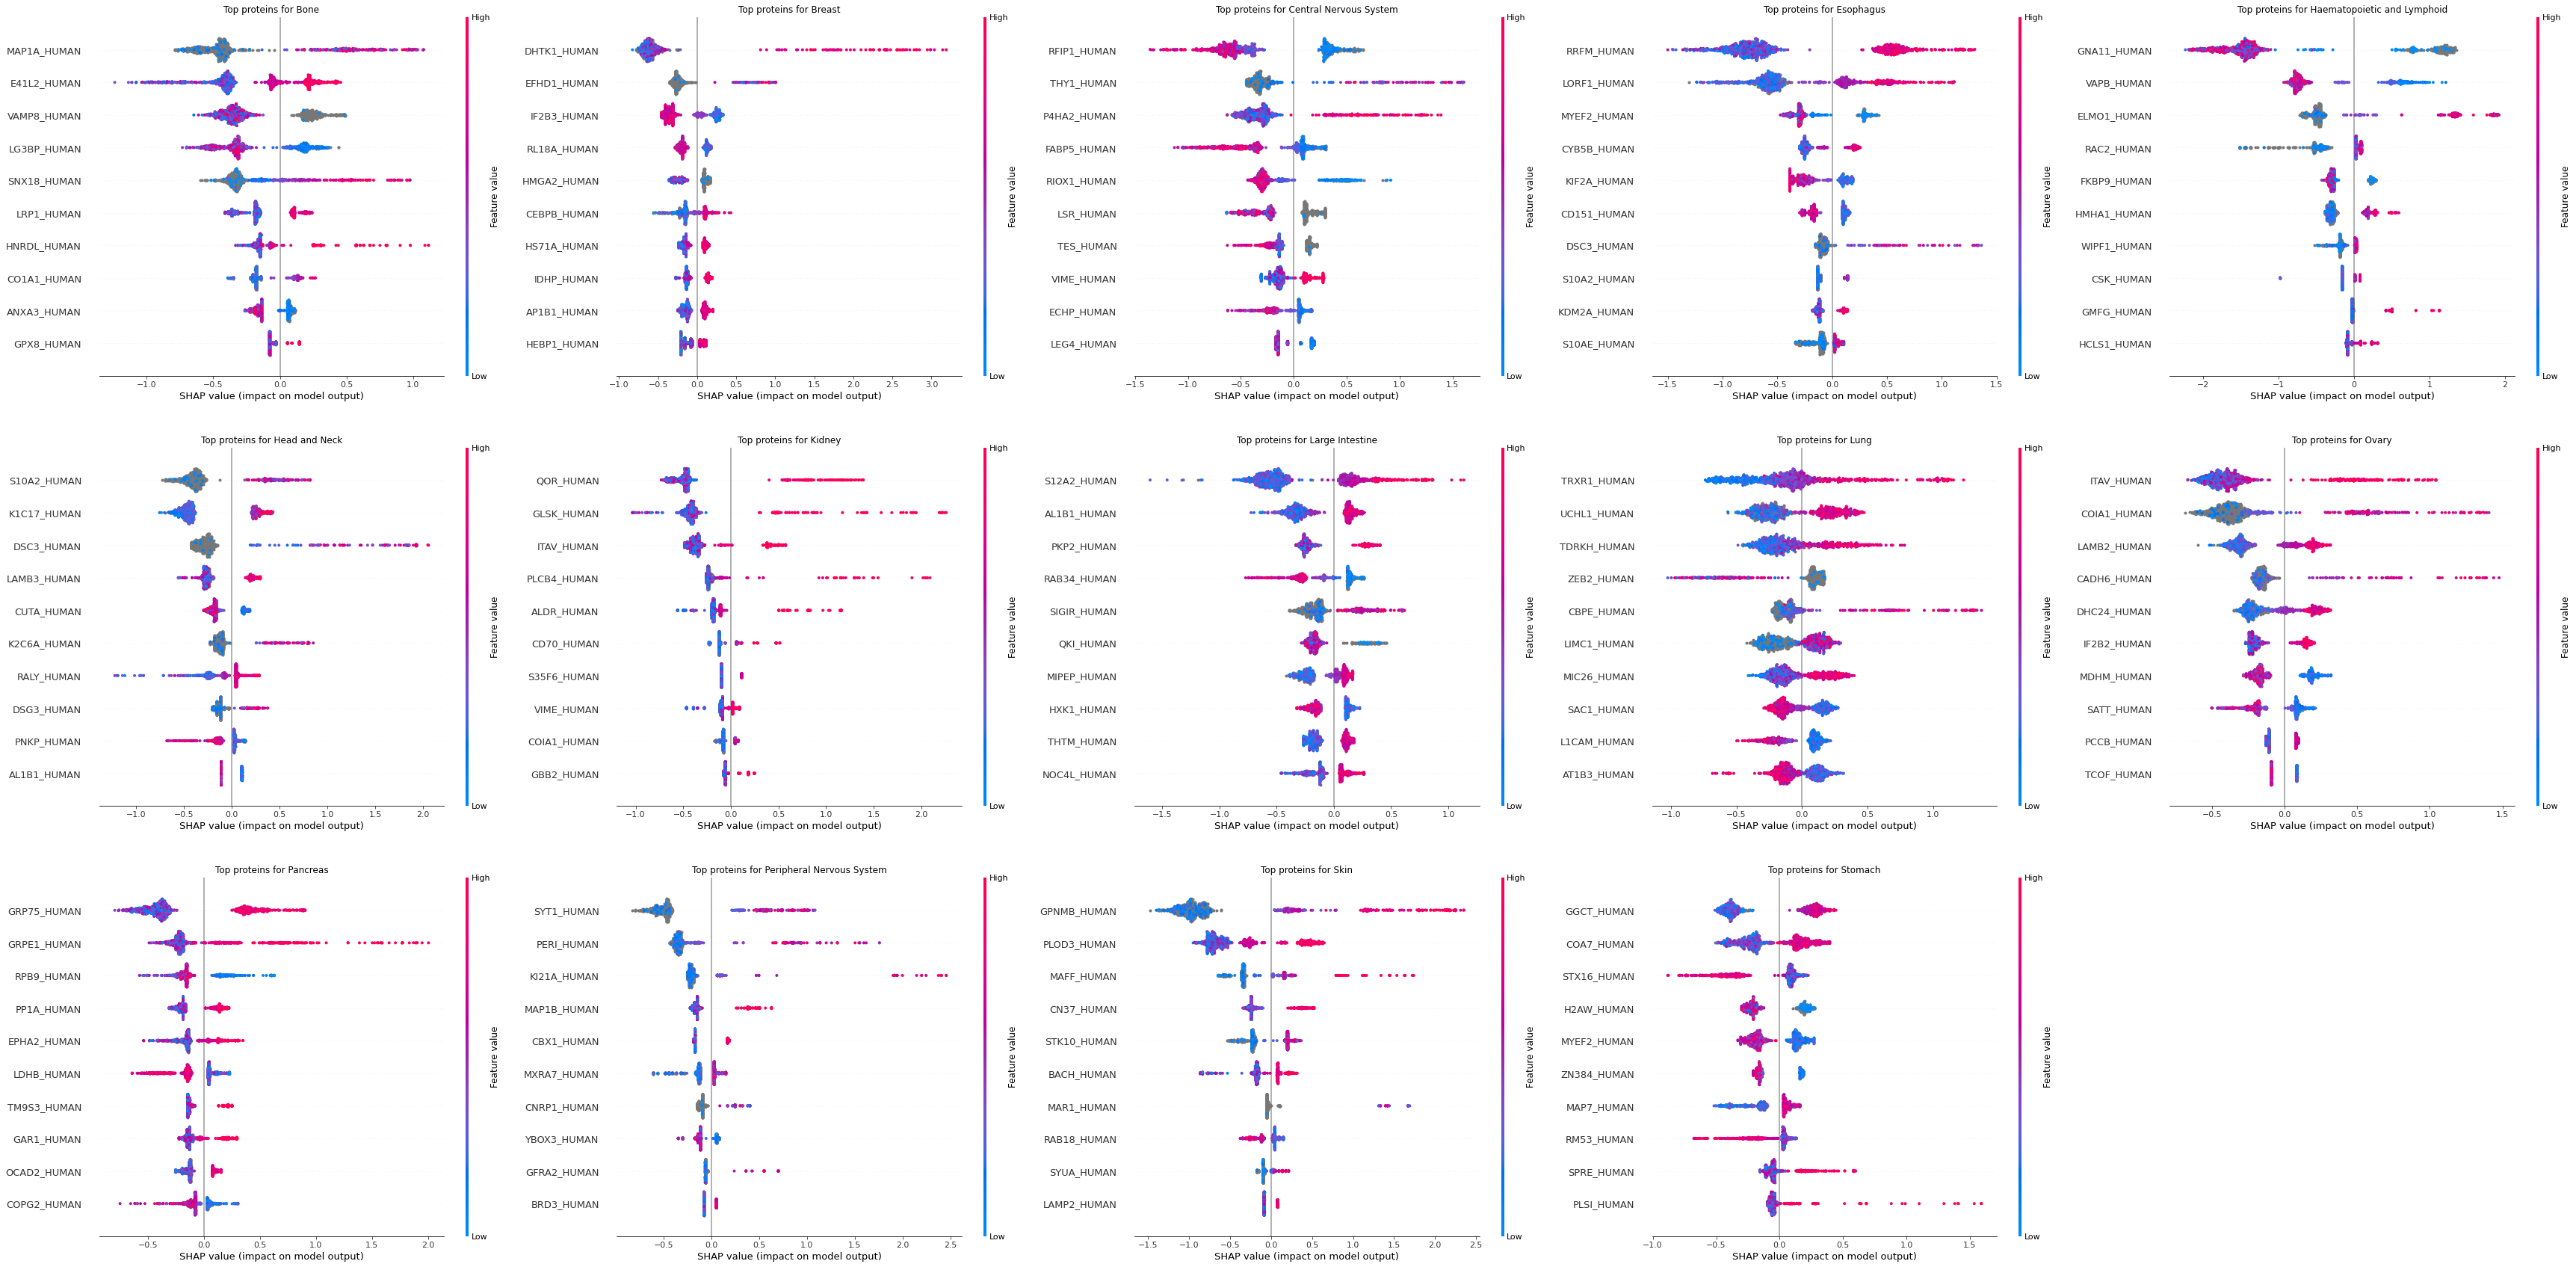

In [162]:
plt.figure(figsize=(60, 30))
for i in range(len(sorted(set(y)))):
    tissue_type = sorted(set(y))[i]
    plt.subplot(3, 5, i + 1)
    plt.title(f'Top proteins for {tissue_type}')
    shap.summary_plot(xgb_shap_values[i],
                      data_sample.iloc[:, :-2],
                      max_display=10,
                      show=False,
                      plot_size=None)
#     ax[i // 5, i % 5].figure = fig